In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


FUNCTIONS

In [2]:
def ar_p_simulator_with_deltas(n, m, phi, drift, sigma):

    AR_prices = []
    AR_deltas = []
    
    # Construct the AR and MA coefficient vectors
    ar = np.array([1] + [-coeff for coeff in phi])  # AR coefficients with 1 at the beginning
    ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])
    
    for _ in range(m):

        arma_process = ArmaProcess(ar, ma)
        simulated_values = arma_process.generate_sample(nsample=n)
        # Add drift to the simulated values
        simulated_values += drift * np.arange(n)
        # Scale the simulated values by the noise standard deviation
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        
        AR_prices.append(AR_price)
        AR_deltas.append(AR_delta)
    
    return np.array(AR_prices), np.array(AR_deltas)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func



PLOT FUNCTIONS

In [3]:
def plot_price_hist(price, deltas, bin_start, bin_stop, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: AR Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: AR Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def supervised_wasserstein(real_data, supervised_data):
    n_timesteps = real_data.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_data[:, t], supervised_data[:, t])
        wasserstein_supervised.append(w_dist)

    # Create visualization
    fig = plt.figure(figsize=(12, 4))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 2)
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.legend()

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_data[:, worst_timestep_supervised]
    generated_data = supervised_data[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()


def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_sequence_metrics(ep_rew, wasserstein, kl_div):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(wasserstein, color='blue')
    axs[1].set_title('Wasserstein Distance')
    axs[1].set_ylabel('WS Distance')
    axs[1].set_xlabel('Model Update')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(disc_loss, disc_acc_1, disc_acc_2, disc_acc_diff):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(disc_loss, color='blue')
    axs[0].set_title('Discriminator Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc_1, color='blue', label='Accuracy First Half')
    axs[1].plot(disc_acc_2, color='green', label='Accuracy Second Half')
    axs[1].axhline(0.5, color='red', linestyle='--', linewidth=1)
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0.4,0.9)
    axs[1].legend()

    axs[2].plot(disc_acc_diff, color='blue')
    axs[2].set_title('Accuracy difference: First vs. Second half of Sequence')
    axs[2].set_ylabel('Accuracy Difference')
    axs[2].set_xlabel('Episode')
    
    plt.show()


def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='GAIL', color='green')
    axs[0].hist(supervised_means, bins=bin_edges_mean, alpha=0.8, label='Supervised', color='red')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # Plot 1: Variance Distribution
    axs[1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='GAIL', color='green')
    axs[1].hist(supervised_variances, bins=bin_edges_var, alpha=0.8, label='Supervised', color='red')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='GAIL', color='green')
    axs[2].hist(supervised_skew, bins=bin_edges_skew, alpha=0.8, label='Supervised', color='red')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def plot_sequences(real_seq, supervised, gail):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue')
        axes[i].plot(supervised[i], label='Supervised', color='red')
        axes[i].plot(gail[i], label='GAIL', color='green')
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 80)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'GAIL')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_supervised]
    generated_data = supervised[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_gail]
    generated_data = gail[:, worst_timestep_gail]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {worst_timestep_gail}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_acf(trajectories, nlags):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def plot_acf_pacf(real_sequences, supervised, gail):

    nlags_acf = len(real_sequences[0])-1
    nlags_pacf = int(len(real_sequences[0])/2-2)
    
    # ACFs for real and simulated trajectories
    real_acfs = calculate_acf([real_sequences[i] for i in range(len(real_sequences))], nlags=nlags_acf)
    avg_real_acf = np.mean(real_acfs, axis=0)
    
    supervised_acfs = calculate_acf([supervised[i] for i in range(len(supervised))], nlags=nlags_acf)
    avg_supervised_acf = np.mean(supervised_acfs, axis=0)

    gail_acfs = calculate_acf([gail[i] for i in range(len(gail))], nlags=nlags_acf)
    avg_gail_acf = np.mean(gail_acfs, axis=0)

    # Calculate PACFs for real and simulated trajectories
    real_pacfs = calculate_pacf([real_sequences[i][1:] for i in range(len(real_sequences))], nlags=nlags_pacf)
    avg_real_pacf = np.mean(real_pacfs, axis=0)
    
    supervised_pacfs = calculate_pacf([supervised[i] for i in range(len(supervised))], nlags=nlags_pacf)
    avg_supervised_pacf = np.mean(supervised_pacfs, axis=0)

    gail_pacfs = calculate_pacf([gail[i] for i in range(len(gail))], nlags=nlags_pacf)
    avg_gail_pacf = np.mean(gail_pacfs, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the averaged ACFs
    axs[0].plot(avg_real_acf, label='Real', color='blue')
    axs[0].plot(avg_supervised_acf, label='Supervised', color='red')
    axs[0].plot(avg_gail_acf, label='GAIL', color='green')
    axs[0].set_title('Average Autocorrelation Function')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Autocorrelation')
    #axs[0].set_xticks(np.arange(0, nlags_acf, 1))
    axs[0].legend()

    # Plot the averaged PACFs
    axs[1].plot(avg_real_pacf, label='Real', color='blue')
    axs[1].plot(avg_supervised_pacf, label='Supervised', color='red')
    axs[1].plot(avg_gail_pacf, label='GAIL', color='green')
    axs[1].set_title('Average Partial Autocorrelation Function')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Partial Autocorrelation')
    #axs[1].set_xticks(np.arange(0, nlags_pacf, 1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def distribution_evolution(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    # Define common range for all histograms
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max for color scaling
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create visualization
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def distribution_evolution_strong_contrast(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histograms (same as before)
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create custom normalization to enhance color contrast
    # Option 1: Using power-law normalization
    from matplotlib.colors import PowerNorm
    norm = PowerNorm(gamma=0.5)  # gamma < 1 will enhance lower values
    
    # Option 2: Alternative - use LogNorm for even more contrast
    # from matplotlib.colors import LogNorm
    # norm = LogNorm(vmin=max(vmin, 0.001), vmax=vmax)  # avoid log(0)
    
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()



$X_t = \mu + 0.6X_{t-1} + 0.4X_{t-2} + 0.3X_{t-3} + 0.1 + \epsilon_t, \quad \epsilon_t \sim N(0, 1)$

**SETTINGS**

In [4]:
phi = [0.6, 0.4, 0.3]       # AR coefficients for positive skew    
drift = 0.1                 # Drift term (constant increment per step)
sigma = 1                   # Standard deviation of noise

n_days = 32                 # Length of each sequence
n_sequences = 30000         # Number of Sequences for training

In [5]:
Price_AR, Delta_AR = ar_p_simulator_with_deltas(n = n_days, m = n_sequences, phi=phi, drift=drift, sigma=sigma)
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_AR)),3))

Standard Deviation of Price Deltas: 6.603


**SETTINGS**

In [6]:
bin_width = 0.65
bin_start=-25
bin_stop=25
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

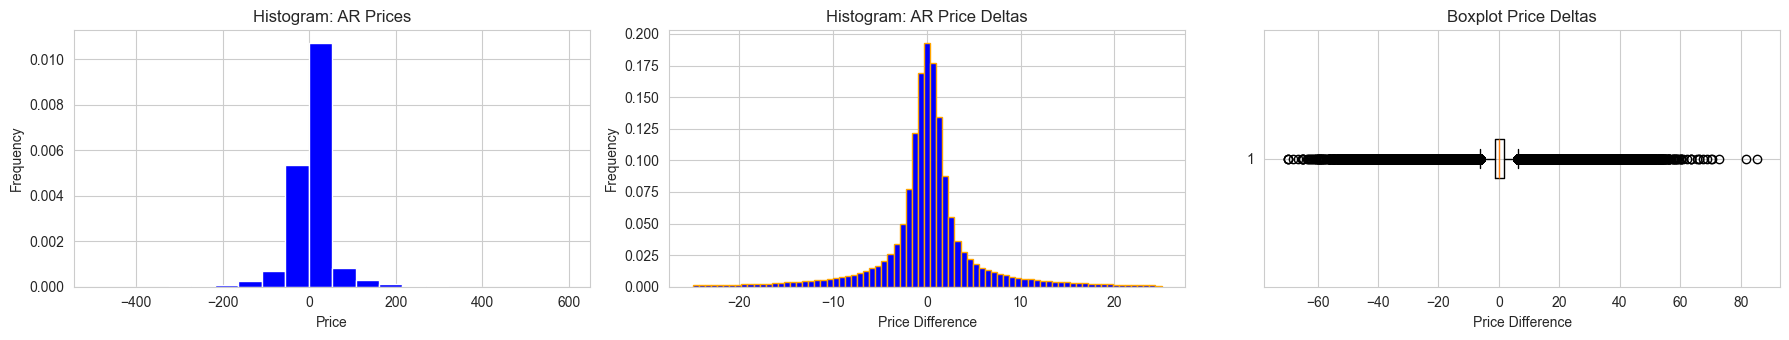

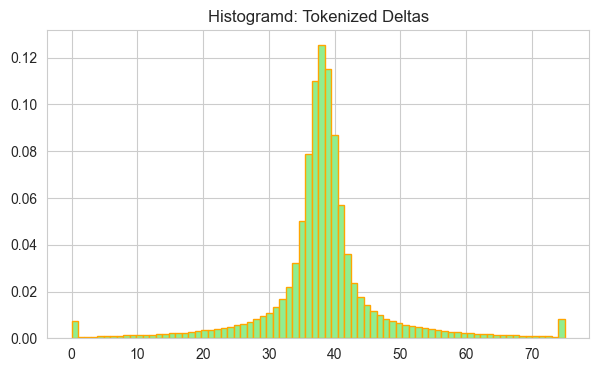

Number of Tokens: 76
Data Shape: (30000, 31)


In [7]:
plot_price_hist(Price_AR, Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plt.figure(figsize=(7,4))
plt.hist(np.concatenate(tokenize_deltas(Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)), bins=token_size, density=True, color='lightgreen', edgecolor='orange')
plt.title('Histogramd: Tokenized Deltas')
plt.show()

print('Number of Tokens:', token_size)
print('Data Shape:', Delta_AR.shape)

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors"""
    # tokens shape: [batch_size, sequence_length]
    batch_size, seq_length = tokens.shape
    onehot = th.zeros(batch_size, seq_length, vocab_size)
    for i in range(batch_size):
        for j in range(seq_length):
            onehot[i, j, tokens[i, j]] = 1
    return onehot

**SETTINGS**

In [9]:
# Rest of your parameters remain the same
hidden_dim = 256
batch_size = 512
learning_rate = 0.001
seq_len = n_days-1
num_epochs = 50

In [ ]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
best_loss = float('inf')
max_grad_norm = 1.0

for epoch in range(num_epochs):
    model_supervised.train()
    temp_loss = []

    # Generate fresh data (this stays the same)
    _, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
    train_data = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

    for batch_idx in range(0, len(train_data), batch_size):
        batch = train_data[batch_idx:batch_idx + batch_size]
        
        # Main changes here: convert inputs to one-hot
        input_tokens = th.tensor(batch[:, :-1], dtype=th.long)  # Changed to long type
        inputs = to_onehot(input_tokens, token_size)  # Convert to one-hot
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.view(-1)
        
        loss = criterion_supervised(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        
        optimizer.step()
        
        temp_loss.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_training_weights.pth')
    
    train_loss.extend(temp_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_loss):.4f}")

Epoch 1/50 - Train Loss: 3.3571
Epoch 2/50 - Train Loss: 2.5401
Epoch 3/50 - Train Loss: 2.3290
Epoch 4/50 - Train Loss: 2.0828
Epoch 5/50 - Train Loss: 1.9931
Epoch 6/50 - Train Loss: 1.9825
Epoch 7/50 - Train Loss: 1.9637
Epoch 8/50 - Train Loss: 1.9564
Epoch 9/50 - Train Loss: 1.9502
Epoch 10/50 - Train Loss: 1.9276
Epoch 11/50 - Train Loss: 1.9218
Epoch 12/50 - Train Loss: 1.9146
Epoch 13/50 - Train Loss: 1.9081
Epoch 14/50 - Train Loss: 1.9020
Epoch 15/50 - Train Loss: 1.9005
Epoch 16/50 - Train Loss: 1.8966
Epoch 17/50 - Train Loss: 1.8911
Epoch 18/50 - Train Loss: 1.8908
Epoch 19/50 - Train Loss: 1.8931
Epoch 20/50 - Train Loss: 1.8903
Epoch 21/50 - Train Loss: 1.8879
Epoch 22/50 - Train Loss: 1.8911
Epoch 23/50 - Train Loss: 1.8872
Epoch 24/50 - Train Loss: 1.8863
Epoch 25/50 - Train Loss: 1.8870
Epoch 26/50 - Train Loss: 1.8833
Epoch 27/50 - Train Loss: 1.8857
Epoch 28/50 - Train Loss: 1.8828
Epoch 29/50 - Train Loss: 1.8822
Epoch 30/50 - Train Loss: 1.8835
Epoch 31/50 - Train

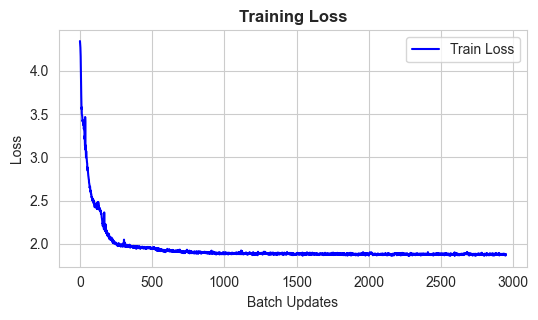

In [45]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Train Loss', color='blue', linewidth=1.5)
plt.title('Training Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

### Supervised Inference

In [10]:
_, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
test_data = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

# Update model creation to match new architecture
inference_model = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_training_weights.pth', weights_only=False))
criterion_inference = nn.CrossEntropyLoss()

test_data_inference = th.tensor(test_data, dtype=th.long)  # Changed to long type

test_losses = []
supervised_data = []

inference_model.eval()

def to_onehot_single(token, vocab_size):
    """Convert single token to one-hot vector"""
    onehot = th.zeros(vocab_size)
    onehot[token.long()] = 1
    return onehot

with th.no_grad():
    for sequence in test_data_inference:
        token_loss = 0
        
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        hidden = None
        
        for i in range(1, len(sequence)):
            # Convert last token to one-hot
            last_token = sim_trajectory[-1]
            input_onehot = to_onehot_single(last_token, token_size).reshape(1, 1, -1)
            
            logits, hidden = inference_model(input_onehot, hidden)
            
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion_inference(logits.squeeze(1), true_token.long())
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

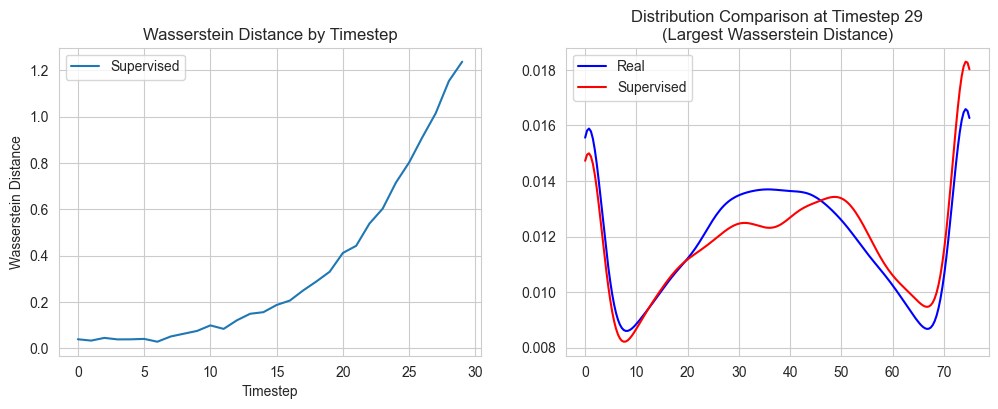

In [11]:
supervised_wasserstein(test_data[:,1:], supervised_data)

### GAIL

In [12]:
class LSTM_Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden

In [13]:
class CustomEnv(gym.Env):
    
    def __init__(self, 
                 sequence_length, token_size, bin_start, bin_stop, bin_width,
                 phi, drift, sigma,
                 discriminator, d_optimizer):
        
        super(CustomEnv, self).__init__()

        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # AR Settings
        self.sequence_length = sequence_length
        self.num_bins = int((bin_stop - bin_start) / bin_width)
        self.bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)
        self.phi = phi
        self.drift = drift
        self.sigma = sigma
        self.ar = np.array([1] + [-coeff for coeff in self.phi])  # AR coefficients with 1 at the beginning
        self.ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])
        
        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

        # Reset
        self.seq_len = None
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
    
    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_seq.append(action)

        ###=====REWARD=====###
        reward = self._get_reward(action)
        ###=====REWARD=====###
        
        done = self._is_done()
        
        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def reset(self, *, seed = None, options = None):

        real_seq = self.get_AR_sequence()

        #self.real_train_seq.append(real_seq[1:])
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _get_reward(self, action):

        self.discriminator.eval()

        with th.no_grad():
            temp_action = th.tensor(np.array([[action]]), dtype=th.long)
            prediction, self.hidden_states = self.discriminator(temp_action, self.hidden_states)
            prediction = prediction[0,0]
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def get_AR_sequence(self):
        
        arma_process = ArmaProcess(self.ar, self.ma)
        simulated_values = arma_process.generate_sample(nsample=self.sequence_length)
        simulated_values += drift * np.arange(self.sequence_length)
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        tokenized_data = np.digitize(AR_delta, bins=self.bin_edges, right=False) - 1
        final_seq = np.clip(tokenized_data, 0, self.num_bins - 1)
        return final_seq

    def discriminator_accuracy(self, real_data, fake_data):
        self.discriminator.eval()
        
        with th.no_grad():
            batch_real = th.tensor(real_data, dtype=th.long)
            batch_fake = th.tensor(fake_data, dtype=th.long)
            
            seq_len = batch_real.size(1)
            split_idx = seq_len // 2
            
            # Full sequence predictions
            real_preds, _ = self.discriminator(batch_real, None)
            fake_preds, _ = self.discriminator(batch_fake, None)
            
            real_probs = th.sigmoid(real_preds)
            fake_probs = th.sigmoid(fake_preds)
            
            # Full accuracy
            correct_real = (real_probs > 0.5).float().sum()
            correct_fake = (fake_probs < 0.5).float().sum()
            total = real_probs.numel() + fake_probs.numel()
            acc_full = (correct_real + correct_fake) / total
            
            # First half accuracy
            correct_real_first = (real_probs[:split_idx] > 0.5).float().sum()
            correct_fake_first = (fake_probs[:split_idx] < 0.5).float().sum()
            total_first = real_probs[:split_idx].numel() + fake_probs[:split_idx].numel()
            acc_1 = (correct_real_first + correct_fake_first) / total_first
            
            # Second half accuracy
            correct_real_second = (real_probs[split_idx:] > 0.5).float().sum()
            correct_fake_second = (fake_probs[split_idx:] < 0.5).float().sum()
            total_second = real_probs[split_idx:].numel() + fake_probs[split_idx:].numel()
            acc_2 = (correct_real_second + correct_fake_second) / total_second
            
            return acc_full.item(), acc_1.item(), acc_2.item(), (acc_2 - acc_1).item()
    
    def train_discriminator(self, batch_real, batch_fake):
        
        self.discriminator.train()
        
        batch_real = th.tensor(batch_real, dtype=th.long)
        batch_fake = th.tensor(batch_fake, dtype=th.long)

        # Forward pass - real data
        real_preds, _ = self.discriminator(batch_real, None)
        real_preds = real_preds.view(-1)
        real_labels = th.ones_like(real_preds) * 0.9  # Label smoothing
        real_loss = self.criterion(real_preds, real_labels)

        # Forward pass - fake data
        fake_preds, _ = self.discriminator(batch_fake, None)
        fake_preds = fake_preds.view(-1)
        fake_labels = th.ones_like(fake_preds) * 0.1  # Label smoothing
        fake_loss = self.criterion(fake_preds, fake_labels)

        # Combined loss and update
        d_loss = (real_loss + fake_loss) / 2
        self.d_optimizer.zero_grad()
        d_loss.backward()
        th.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)  # Add gradient clipping
        self.d_optimizer.step()

        with th.no_grad():
            discriminator_loss = d_loss.item()
        
        return discriminator_loss


In [40]:
class CustomCallback(BaseCallback):

    def __init__(self, verbose, display_rollout, disc_batch_size):
        
        super(CustomCallback, self).__init__(verbose)
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        
        self.batch_size = disc_batch_size

        # KL and Wasserstein
        self.sequence_metrics = {
            'kl_div': [],
            'wasserstein': []
        }

        # Metrics after every network update of the discriminator
        self.disc_metrics_per_batch = {
            'loss': [], 
            'accuracy': [],
            'accuracy_1': [],
            'accuracy_2': [],
            'accuracy_difference': [],
            'n_batches': []
        }

        # Save best model
        self.best_wasserstein = float('inf')  # Initialize with infinity
        self.best_model_path = "best_GAIL_model"   # Path to save best model

    def _on_training_start(self) -> None:
        pass

    def _on_rollout_start(self) -> None:
        
        self.save_losses()

        real_data, fake_data = self.get_sequences_batch(n = 1000)

        wasser_dist = self.calculate_wasserstein_distance(real_data, fake_data)
        kl_div = self.calculate_kl_divergence(real_data, fake_data)

        self.sequence_metrics['wasserstein'].append(wasser_dist)
        self.sequence_metrics['kl_div'].append(kl_div)

        for env in self.training_env.envs:

            pre_acc, _, _, pre_diff = env.unwrapped.discriminator_accuracy(real_data, fake_data)

            min_accuracy = 0.60     # Don't want discriminator too weak
            max_accuracy = 0.80     # Don't want discriminator too strong
            min_batches = 0         # Minimum batches to train on
            max_batches = 100       # Minimum batches to train on
            
            for batch in range(max_batches):
                
                real_batch, fake_batch = self.get_sequences_batch(n=batch_size)
                batch_loss = env.unwrapped.train_discriminator(real_batch, fake_batch)
                curr_acc, curr_acc_1, curr_acc_2, curr_acc_diff = env.unwrapped.discriminator_accuracy(real_batch, fake_batch)
                
                self.disc_metrics_per_batch['loss'].append(batch_loss)
                self.disc_metrics_per_batch['accuracy'].append(curr_acc)
                self.disc_metrics_per_batch['accuracy_1'].append(curr_acc_1)
                self.disc_metrics_per_batch['accuracy_2'].append(curr_acc_2)
                self.disc_metrics_per_batch['accuracy_difference'].append(curr_acc_diff)

                if batch >= min_batches:

                    if curr_acc > max_accuracy:
                        print(f"Discriminator too strong ({curr_acc:.3f}), stopping")
                        break

                    recent_acc = np.mean(self.disc_metrics_per_batch['accuracy'][-3:])  # Last 3 batches
                    if 0.65 < recent_acc < 0.80 and np.std(self.disc_metrics_per_batch['accuracy'][-3:]) < 0.02:
                        print(f"Discriminator stable at {recent_acc:.3f}, stopping")
                        break

                    # Stop if no improvement in last 5 batches
                    if batch > 5 and np.std(self.disc_metrics_per_batch['accuracy'][-5:]) < 0.01:
                        print("Discriminator converged, stopping")
                        break
                
            self.disc_metrics_per_batch['n_batches'].append(batch + 1)
            
            post_acc, _, _, post_diff = env.unwrapped.discriminator_accuracy(real_data, fake_data)

            print(f"Wasserstein: {wasser_dist:.3f} - KL Div: {kl_div:.3f} - Stopped after {batch + 1} batches")
            print(f"Pre Accuracy: {pre_acc:.3f} - Post Accuracy: {post_acc:.3f} - Pre Acc Diff: {pre_diff:.3f} - Post Acc Diff: {post_diff:.3f}")
    
    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()
    
    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def get_sequences(self, n):

        real_data = []
        fake_data = []
        
        for env in self.training_env.envs:

            for _ in range(n):

                real_seq = env.unwrapped.get_AR_sequence()

                curr_seq = []
                action = real_seq[0]
                lstm_states = None
                episode_starts = np.ones((1,), dtype=bool)

                for _ in range(len(real_seq)-1):

                    action, lstm_states = self.model.predict(action, state=lstm_states, episode_start=episode_starts, deterministic=False)
                    episode_starts = np.ones((0,), dtype=bool)
                    curr_seq.append(action.item())

                fake_data.append(curr_seq)
                real_data.append(real_seq[1:])
        
        return np.array(real_data), np.array(fake_data)

    def get_sequences_batch(self, n):

        real_data = []
        fake_data = []
        
        # 1. Batch process for each environment
        for env in self.training_env.envs:
            # Get all real sequences at once
            real_seqs = [env.unwrapped.get_AR_sequence() for _ in range(n)]
            
            # Prepare batch for model.predict
            batch_size = n
            actions = np.array([seq[0] for seq in real_seqs])
            lstm_states = None
            episode_starts = np.ones((batch_size,), dtype=bool)
            
            # Initialize all fake sequences
            curr_seqs = [[] for _ in range(batch_size)]
            seq_len = len(real_seqs[0]) - 1
            
            # Generate all sequences in parallel
            for _ in range(seq_len):
                # Predict entire batch at once
                actions, lstm_states = self.model.predict(
                    actions,
                    state=lstm_states,
                    episode_start=episode_starts,
                    deterministic=False
                )
                
                # Update all sequences at once
                for i, action in enumerate(actions):
                    curr_seqs[i].append(action.item())
                
                episode_starts = np.zeros((batch_size,), dtype=bool)
            
            # Append results
            fake_data.extend(curr_seqs)
            real_data.extend([seq[1:] for seq in real_seqs])
        
        return np.array(real_data), np.array(fake_data)
    
    def calculate_wasserstein_distance(self, real_data, fake_data):
        
        wasserstein_distances = []
        for i in range(len(real_data[0])):
            w_dist = wasserstein_distance(real_data[:, i], fake_data[:, i])
            wasserstein_distances.append(w_dist)

        # Different ways to analyze the results
        return np.mean(wasserstein_distances)  # Overall performance
    
    def calculate_kl_divergence(self, real_sequences, fake_sequences, eps=1e-10):

        # Flatten sequences and count tokens
        real_tokens = np.concatenate(real_sequences)
        fake_tokens = np.concatenate(fake_sequences)
        
        # Get unique vocabulary from both distributions
        vocab = set(real_tokens) | set(fake_tokens)
        
        # Calculate token counts and totals
        real_counts = Counter(real_tokens)
        fake_counts = Counter(fake_tokens)
        
        total_real = len(real_tokens)
        total_fake = len(fake_tokens)
        
        # Calculate probabilities with smoothing for all tokens in vocabulary
        real_probs = {token: (real_counts.get(token, 0) + eps) / (total_real + eps * len(vocab))
                    for token in vocab}
        fake_probs = {token: (fake_counts.get(token, 0) + eps) / (total_fake + eps * len(vocab))
                    for token in vocab}
        
        # Calculate KL divergence
        kl_div = sum(p_real * np.log2(p_real / fake_probs[token])
                    for token, p_real in real_probs.items())
        
        return kl_div



In [46]:
discriminator = LSTM_Discriminator(vocab_size=token_size, embedding_dim=32, hidden_dim=256)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

env_GAIL = CustomEnv(n_days, token_size, bin_start, bin_stop, bin_width,
                     phi, drift, sigma, discriminator, d_optimizer)

env_GAIL = Monitor(env_GAIL, filename=None)

model_GAIL = RecurrentPPO(

    policy='MlpLstmPolicy',
    env=env_GAIL,
    verbose=0,

    n_steps=1000*30,                        # Reasonable episode length * number of episodes
    batch_size=10*30,                       # Small enough for stable updates
    n_epochs=10,                            # Standard PPO epochs
    
    clip_range=0.2,                         # Standard PPO clipping
    ent_coef=0.10,                          # Moderate exploration
    vf_coef=0.75,                           # Balanced value function importance
    gamma=0.99,                             # Standard discount
    gae_lambda=0.95,                        # Standard GAE lambda

    learning_rate=1e-4,    # Standard starting LR
    
    policy_kwargs=dict(
        lstm_hidden_size=256,
        n_lstm_layers=2,
        net_arch=dict(pi=[], vf=[]),
        shared_lstm=True,  # Use shared LSTM
        enable_critic_lstm=False,  # Disable separate critic LSTM
    )
)

callback_GAIL = CustomCallback(verbose=0, display_rollout=False, disc_batch_size=128)

In [47]:
model_GAIL.learn(2400000, callback=callback_GAIL)
env_GAIL.close()

Discriminator stable at 0.706, stopping
Wasserstein: 13.662 - KL Div: 1.522 - Stopped after 1 batches
Pre Accuracy: 0.525 - Post Accuracy: 0.706 - Pre Acc Diff: 0.008 - Post Acc Diff: 0.021
Discriminator stable at 0.722, stopping
Wasserstein: 13.401 - KL Div: 1.490 - Stopped after 1 batches
Pre Accuracy: 0.704 - Post Accuracy: 0.732 - Pre Acc Diff: 0.020 - Post Acc Diff: 0.024
Discriminator stable at 0.758, stopping
Wasserstein: 13.393 - KL Div: 1.500 - Stopped after 2 batches
Pre Accuracy: 0.720 - Post Accuracy: 0.788 - Pre Acc Diff: -0.010 - Post Acc Diff: -0.031
Discriminator too strong (0.805), stopping
Wasserstein: 13.613 - KL Div: 1.553 - Stopped after 1 batches
Pre Accuracy: 0.794 - Post Accuracy: 0.801 - Pre Acc Diff: -0.012 - Post Acc Diff: -0.014
Discriminator too strong (0.805), stopping
Wasserstein: 13.804 - KL Div: 1.546 - Stopped after 1 batches
Pre Accuracy: 0.801 - Post Accuracy: 0.808 - Pre Acc Diff: 0.057 - Post Acc Diff: 0.054
Discriminator too strong (0.806), stoppi

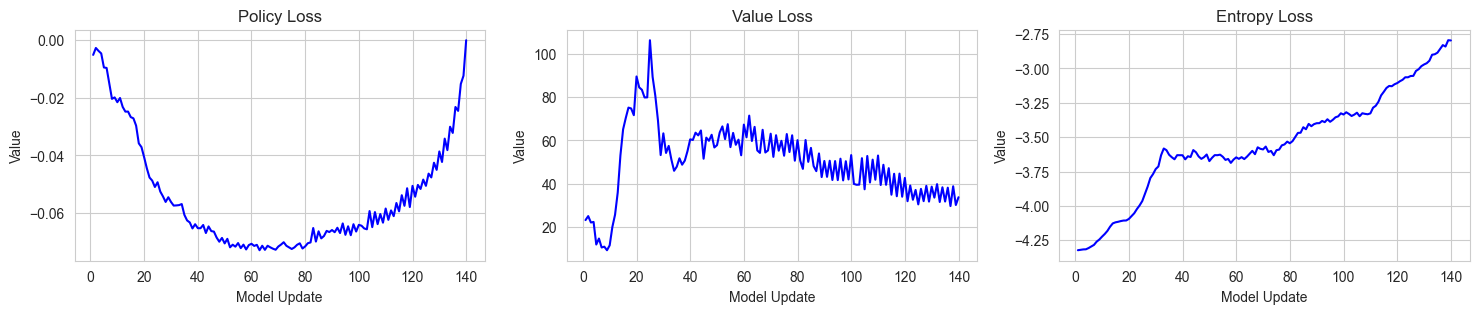

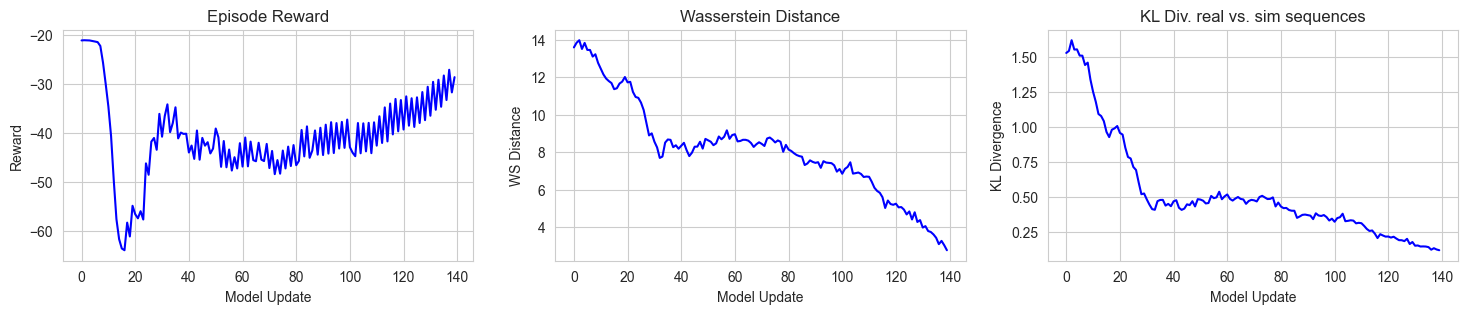

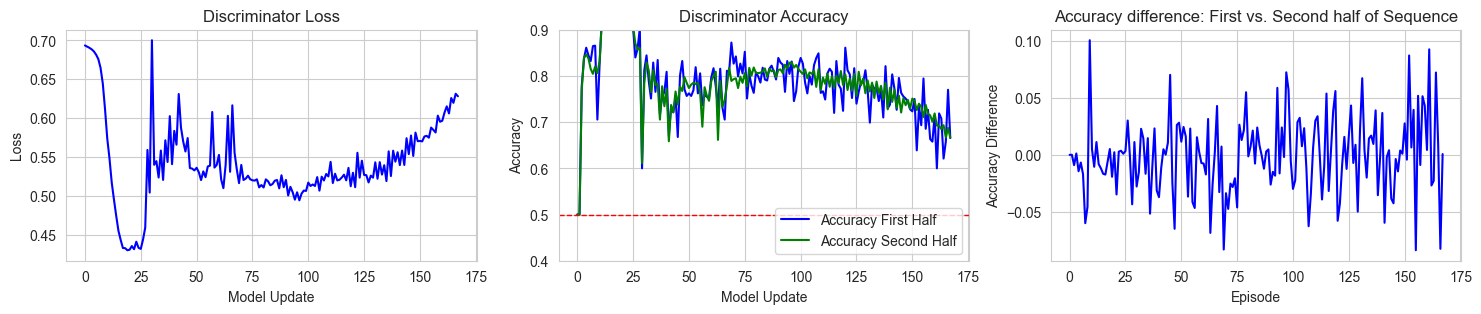

In [45]:
plot_losses(callback_GAIL.pg_losses, callback_GAIL.value_losses, callback_GAIL.entropy_losses)
plot_sequence_metrics(callback_GAIL.rewards, callback_GAIL.sequence_metrics['wasserstein'],
                      callback_GAIL.sequence_metrics['kl_div'])
plot_discriminator(callback_GAIL.disc_metrics_per_batch['loss'],
                   callback_GAIL.disc_metrics_per_batch['accuracy_1'],
                   callback_GAIL.disc_metrics_per_batch['accuracy_2'],
                   callback_GAIL.disc_metrics_per_batch['accuracy_difference'])

In [35]:
real_data, gail_data = callback_GAIL.get_sequences_batch(10000)

In [36]:
real_means, real_variances, real_std_devs, real_skew, real_kurtosis = calculate_statistics(real_data)
supervised_means, supervised_variances, supervised_std_devs, supervised_skew, supervised_kurtosis = calculate_statistics(supervised_data)
gail_means, gail_variances, gail_std_devs, gail_skew, gail_kurtosis = calculate_statistics(gail_data)


In [37]:
bin_start_mean = min(np.min(supervised_means), np.min(real_means))
bin_stop_mean = max(np.max(supervised_means), np.max(real_means))
bin_start_var = min(np.min(supervised_variances), np.min(real_variances))
bin_stop_var = max(np.max(supervised_variances), np.max(real_variances))
bin_start_skew = min(np.min(supervised_skew), np.min(real_skew))
bin_stop_skew = max(np.max(supervised_skew), np.max(real_skew))

bin_width_mean = 1
bin_width_var = 10
bin_width_skew = 0.30

bin_edges_mean = np.arange(bin_start_mean, bin_stop_mean + bin_width_mean, bin_width_mean)
bin_edges_var = np.arange(bin_start_var, bin_stop_var + bin_width_var, bin_width_var)
bin_edges_skew = np.arange(bin_start_skew, bin_stop_skew + bin_width_skew, bin_width_skew)

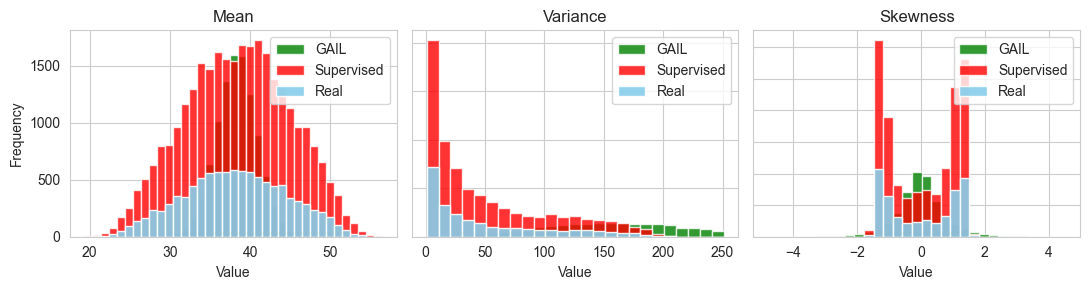

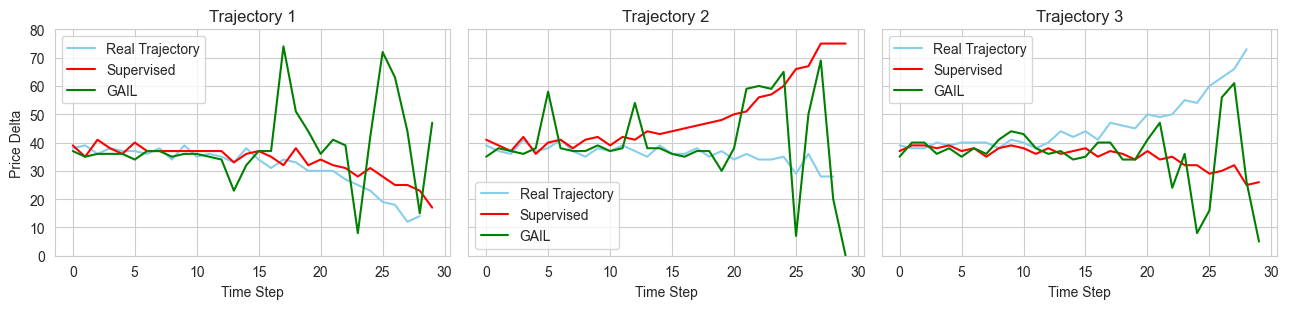

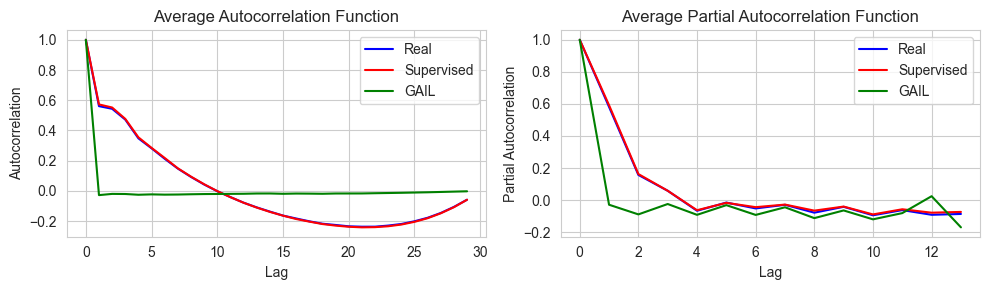

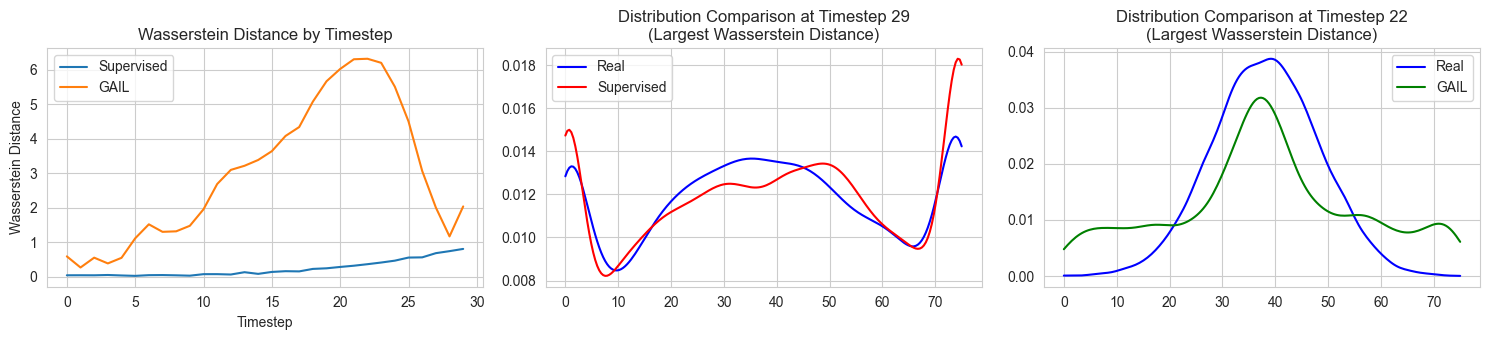

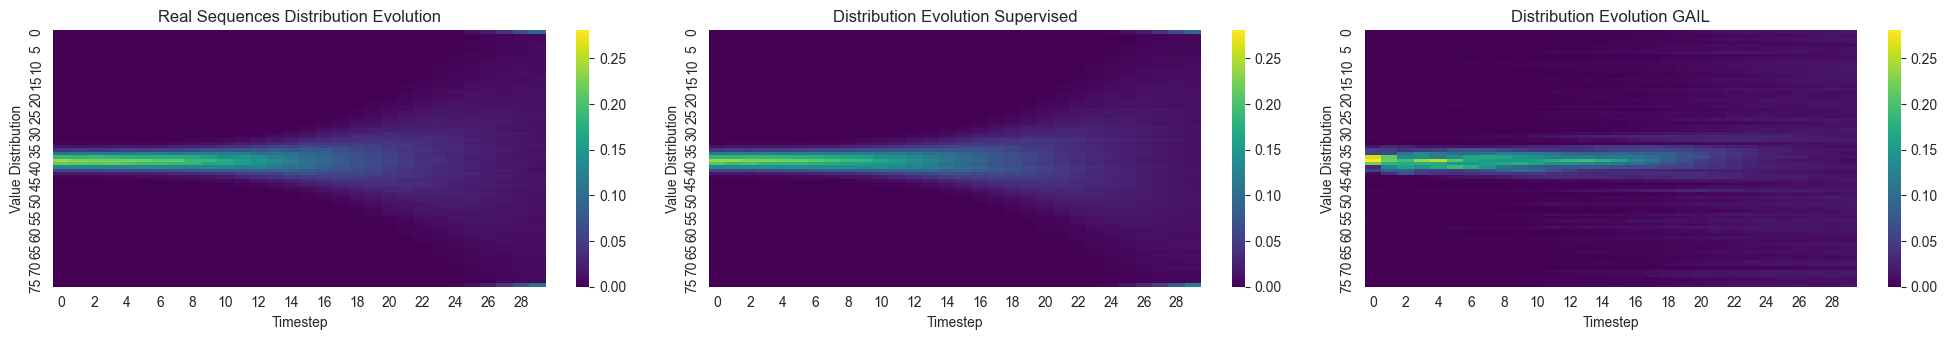

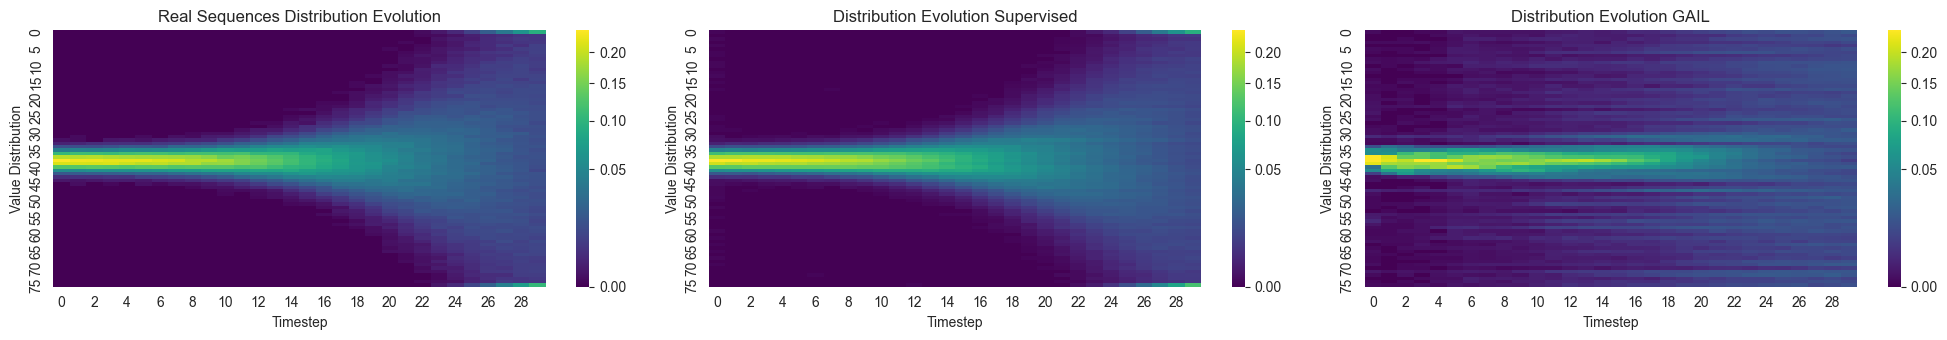

In [38]:
plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew)

plot_sequences(real_data, supervised_data, gail_data)
plot_acf_pacf(real_data, supervised_data, gail_data)
wasserstein_dist(real_data, supervised_data, gail_data)
distribution_evolution(real_data, supervised_data, gail_data, token_size)
distribution_evolution_strong_contrast(real_data, supervised_data, gail_data, token_size)

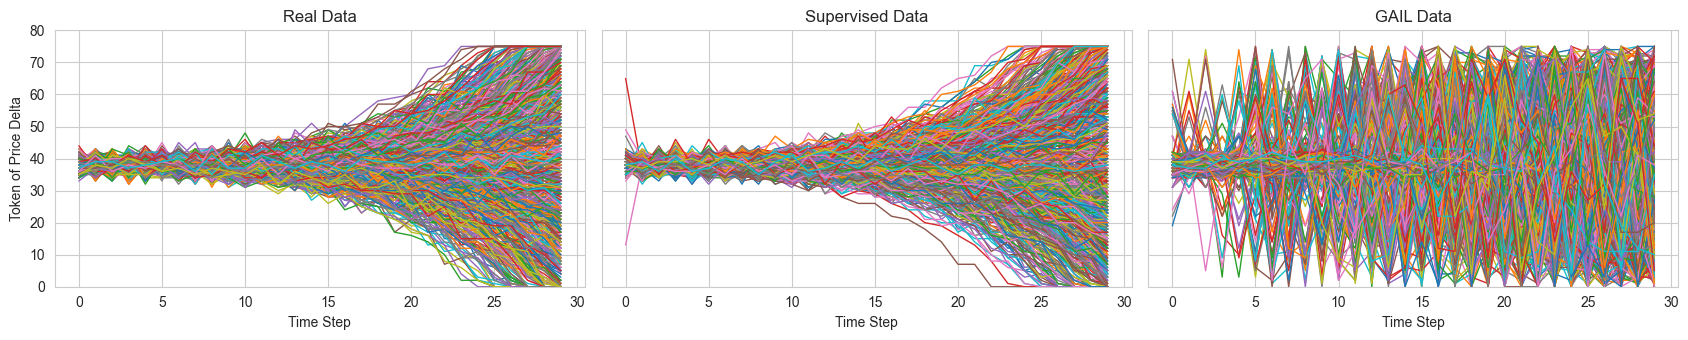

In [39]:
# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(17, 3.5))  # 1 row, 3 columns
axes = axes.flatten()

# Plot the real and simulated trajectories
for i in range(1000):
    axes[0].plot(real_data[i], linewidth=1)
    axes[1].plot(supervised_data[i], linewidth=1)
    axes[2].plot(gail_data[i], linewidth=1)

axes[0].set_title('Real Data')
axes[0].set_ylim(0, 80)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Token of Price Delta')

axes[1].set_title('Supervised Data')
axes[1].set_ylim(0, 80)
axes[1].set_xlabel('Time Step')
axes[1].tick_params(labelleft=False)

axes[2].set_title('GAIL Data')
axes[2].set_ylim(0, 80)
axes[2].set_xlabel('Time Step')
axes[2].tick_params(labelleft=False)

# Adjust spacing between plots to bring them closer
plt.subplots_adjust(wspace=0)  # Reduce space between plots
plt.tight_layout()
plt.show()